# Contextual multi-armed bandits

Today we will simulate an ads campaign. Our aim is to find a way
to optimize ads for three type of users, optimizing the
clickthrough rate (CTR).

We will implement the following algorithms:

- Explore and Commit
- ε-Greedy
- Bayes Optimization
- Beta Thompson Sampling

In [ ]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
import pandas as pd
import numpy as np
import random

Let’s suppose our True CTR are the following:

In [ ]:
CTR_dict = {
    'AI Engineer':{
        'RL Course by RC': 0.3,
        'Optimization course at Amazon': 0.2,
        'Trading Course by TikTok Guru': 0.03,
    },
    'Management Engineer':{
        'RL Course by RC': 0.08,
        'Optimization course at Amazon': 0.3,
        'Trading Course by TikTok Guru': 0.05,
    },
    'High School Kid':{
        'RL Course by RC': 0.05,
        'Optimization course at Amazon': 0.1,
        'Trading Course by TikTok Guru': 0.1,
    }
}

In [ ]:
CTR_df = pd.DataFrame(CTR_dict).T

In [ ]:
CTR_df

,RL Course by RC,Optimization course at Amazon,Trading Course by TikTok Guru
AI Engineer,0.30,0.2,0.03
Management Engineer,0.08,0.3,0.05
High School Kid,0.05,0.1,0.10


In [ ]:
CTR = CTR_df.to_numpy()

In [ ]:
class Environment:
    def __init__(self, CTR):
        self.CTR = CTR
        self.n_states, self.n_actions = self.CTR.shape
        self.current_state = None

    def observe(self):
        self.current_state = np.random.randint(self.n_states)
        return self.current_state

    def step(self, action):
        p = self.CTR[self.current_state, action]

        if np.random.rand() < p:
            return 1

        return 0

In [ ]:
class Agent:
    def __init__(self, env):
        self.env = env
        self.clicks = np.zeros((self.env.n_states, self.env.n_actions))
        self.views = np.zeros((self.env.n_states, self.env.n_actions))
        self.Q = np.zeros((self.env.n_states, self.env.n_actions))

    def evaluate(self, iters = 20):
        reward = 0
        for i in range(iters):
            state = self.env.observe()
            action = self.Q[state,:].argmax()
            click = self.env.step(action)
            reward += ...
        return reward/iters

    def regret(self):
        regret = 0
        for s in range(self.env.n_states):
            state = self.env.observe()
            action = self.Q[state,:].argmax()
            best_action = env.CTR[state,:].argmax()
            regret += ...
        return regret/self.env.n_states

## Explore & Commit
1.   For t = 0, ..., T: (explore)
  *   observe state x
  *   sample a ~ Unif(A)
  *   observe reward and compute empirical mean

2.   For t = N, ..., T-1: (commit)
  *   perform best empirical action

In [ ]:
class ExploreCommit(Agent):

    def train(self, iters = 20):
        for i in range(iters):
            state = self.env.observe()
            if self.views[state,:].min() == 0:
                action = ...
            else:
                action = ...

            click = self.env.step(action)

            self.views[state, action] += ...
            self.clicks[state, action] += ...
            self.Q[state, action] = ...


## $\epsilon$-Greedy
1.   For t = 0, ..., T: (explore and exploit)
  *   observe state x
  *   a ~ (1-ε)a* + εUnif(A)
  *   observe reward and update estimate

2.   For t = N, ..., T-1: (commit)
  *   pull the best empirical arm

In [ ]:
class EpsilonGreedy(Agent):
    def __init__(self, env, epsilon=0.2):
        super().__init__(env)
        self.epsilon = epsilon

    def train(self, iters = 20):
        for i in range(iters):
            state = self.env.observe()
            if self.views[state,:].min() == 0:
                action = ...
            else:
                action = ...
            click = self.env.step(action)
            self.views[state, action] += ...
            self.clicks[state, action] += ...
            self.Q[state, action] = ...


## Bayesian Sampling
1.   For t = 0, ..., T: (explore and exploit)
  *   sample r independently from N(mu, sigma)
  *   a ~ best action among sampled one
  *   observe reward and update posterior distribution

PS: We will use discrete bernoulli distribution, without
sigma

In [ ]:
class DBSampling(Agent):
    def update_posterior(self, state):
        for a in range(self.env.n_actions):
            evidence = ...
            likelihood = ...
            prior = ...
            self.Q[state, a] = ...

    def train(self, iters = 20):
        for i in range(iters):
            state = self.env.observe()


            if self.views[state,:].min() == 0:
                action = ...
            else:
                outcomes = []
                for a in range(self.env.n_actions):
                    click_hat = ...
                    outcomes.append((click_hat, a))
                random.shuffle(outcomes)

                action = ...

            click = self.env.step(action)
            self.views[state, action] += ...
            self.clicks[state, action] += ...


            if self.views[state,:].min() != 0 and self.clicks[state,:].sum() != 0:
                self.update_posterior(state)


## Beta distribution

E(x) = α/(α+β)
Var(x) = αβ/(α+β)2

(α+β+1)

*   High α and β, small variance
*   High α, high mean
*   High β, small mean

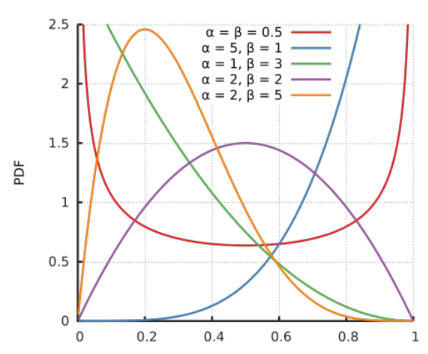

## Beta-distribution Thompson Sampling

1.  For t = 0, ..., T:
  * sample r independently from Beta(alpha, beta)
  * a ~ best action among sampled one
  * observe reward
  * if r == 1 then alpha+=1 else beta += 1

In [ ]:
class BSampling(Agent):
    def __init__(self, env):
        super().__init__(env)
        self.alphas = np.ones((self.env.n_states, self.env.n_actions))
        self.betas = np.ones((self.env.n_states, self.env.n_actions))

    def update_posterior(self, state):
        for a in range(self.env.n_actions):
            alpha = self.alphas[state, a]
            beta = self.betas[state, a]
            self.Q[state, a] = ...

    def train(self, iters = 20):
        for i in range(iters):
            state = self.env.observe()


            if self.views[state,:].min() == 0:
                action = self.views[state,:].argmin()
            else:
                outcomes = []
                for a in range(self.env.n_actions):
                    click_hat = ...
                    outcomes.append(...)
                random.shuffle(outcomes)

                action = ...

            click = self.env.step(action)
            self.views[state, action] += ...
            self.clicks[state, action] += ...

            if click:
                self.alphas[state, action] += ...
            else:
                self.betas[state, action] += ...

            if self.views[state,:].min() != 0 and self.clicks[state,:].sum() != 0:
                self.update_posterior(state)


In [ ]:
env = Environment(CTR)

In [ ]:
methods = [ExploreCommit, EpsilonGreedy, DBSampling, BSampling]

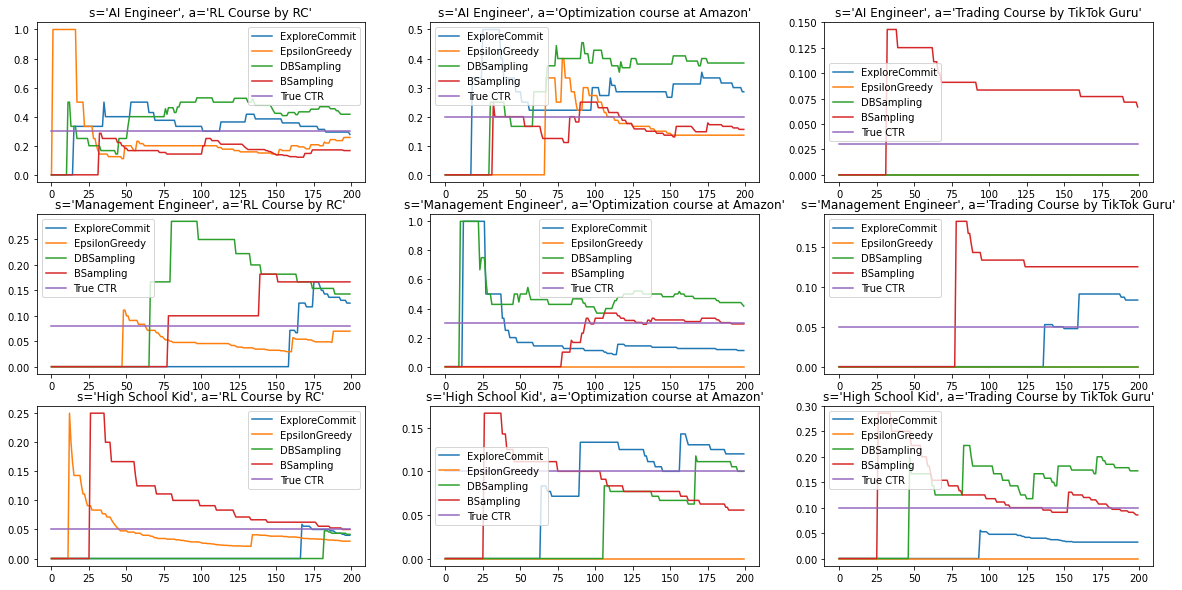

In [ ]:
import matplotlib.pyplot as plt


agents = []
logs = []
for method in methods:
    agent = method(env)
    logs.append([])
    agents.append(agent)

for i in range(200):
    for j, agent in enumerate(agents):
        agent.train(1)
        logs[j].append(agent.Q.copy())


plt.figure(figsize=(20,10))
i = 0
for s in range(env.n_states):
    for a in range(env.n_actions):
        i=i+1
        ax = plt.subplot(env.n_states, env.n_actions, i)
        ax.set_title(f"s='{CTR_df.index[s]}', a='{CTR_df.columns[a]}'")
        for j, log in enumerate(logs):
            ax.plot([l[s,a] for l in log], label=agents[j].__class__.__name__)
        ax.plot([CTR[s,a]]*len(logs[0]), label='True CTR')

        ax.legend()

In [ ]:
for agent in agents:
    print(agent.__class__.__name__)
    print('Reward:', agent.evaluate())
    print('Regret:', agent.regret())
    print()

ExploreCommit
Reward: 0.05
Regret: 0.10666666666666665

EpsilonGreedy
Reward: 0.1
Regret: 0.03333333333333333

DBSampling
Reward: 0.15
Regret: 0.0

BSampling
Reward: 0.15
Regret: 0.0



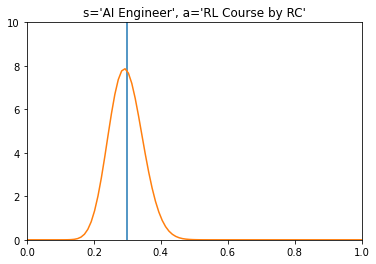

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import beta as beta_dist
from matplotlib.animation import FuncAnimation
from matplotlib import animation

%matplotlib inline
fig, ax = plt.subplots()
ax.set_xlim(0,1)
ax.set_ylim(0,10)
agents = []
logs = []
agent = BSampling(env)
# line_plotted = plt.plot([])
line_plotted=None
x = np.linspace(0,1,100)
for i in range(300):
    agent.train(1)
    logs.append((agent.alphas.copy(), agent.betas.copy()))


s = 0
a = 0
ax.plot(np.linspace(0,10,100)*0+CTR[s,a],np.linspace(0,10,100), label='True CTR')

plt.title(f"s='{CTR_df.index[s]}', a='{CTR_df.columns[a]}'")

def animation_f(frame):
    if frame >= len(logs):
        frame = len(logs)-1
    global line_plotted
    alphas, betas = logs[frame]
    alpha = alphas[s,a]
    beta = betas[s,a]

    rv = beta_dist(alpha, beta)
    if line_plotted is None:
        line_plotted = ax.plot(x, rv.pdf(x))
    line_plotted[0].set_data((x, rv.pdf(x)))


i = 0


anim_created = FuncAnimation(fig, animation_f, frames=len(logs)+100, interval=10)
writervideo = animation.FFMpegWriter(fps=60)
anim_created.save('anim.mp4', writer=writervideo)

plt.show()
plt.close()